In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 150)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io

# ---- 2.1 Load USAFacts county-level cumulative cases, build Georgia daily new cases ----
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 150)

USAF_CSV = "https://static.usafacts.org/public/data/covid-19/covid_confirmed_usafacts.csv"

try:
    df_all = pd.read_csv(USAF_CSV)
except requests.exceptions.HTTPError as e:
    if e.response.status_code == 403:
        print("HTTP Error 403: Forbidden. Attempting to fetch with requests.")
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
        response = requests.get(USAF_CSV, headers=headers)
        response.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)
        df_all = pd.read_csv(io.StringIO(response.text))
    else:
        raise
except Exception as e:
    # Catch other potential errors during initial read_csv attempt
    print(f"Initial read_csv failed with: {e}. Attempting to fetch with requests.")
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    response = requests.get(USAF_CSV, headers=headers)
    response.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)
    df_all = pd.read_csv(io.StringIO(response.text))

required_cols = {"countyFIPS", "County Name", "State"}
missing_req = required_cols - set(df_all.columns)
if missing_req:
    raise ValueError(f"Unexpected USAFacts schema. Missing columns: {missing_req}")

df_ga = df_all[df_all["State"] == "GA"].copy()

date_cols = [c for c in df_ga.columns if c not in ["countyFIPS", "County Name", "State", "stateFIPS"]]

ga_cumulative = df_ga[date_cols].sum(axis=0)

df_ga_cum = (
    ga_cumulative
    .reset_index()
    .rename(columns={"index": "date", 0: "cumulative_cases"})
)
df_ga_cum["date"] = pd.to_datetime(df_ga_cum["date"], errors="coerce")
df_ga_cum = df_ga_cum.sort_values("date").dropna(subset=["date"])

df_ga_cum["new_cases"] = df_ga_cum["cumulative_cases"].diff().clip(lower=0).fillna(0)

start, end = pd.Timestamp("2020-05-01"), pd.Timestamp("2020-05-31")
mask_may = (df_ga_cum["date"] >= start) & (df_ga_cum["date"] <= end)
df_ga_may = df_ga_cum.loc[mask_may].copy()

df_ga_may["new_cases_7d"] = df_ga_may["new_cases"].rolling(window=7, min_periods=1).mean()

print("GA May 2020 rows:", len(df_ga_may))
display(df_ga_may.head(10))

Initial read_csv failed with: HTTP Error 403: Forbidden. Attempting to fetch with requests.
GA May 2020 rows: 31


/tmp/ipython-input-776497493.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ga_cum["date"] = pd.to_datetime(df_ga_cum["date"], errors="coerce")


,date,cumulative_cases,new_cases,new_cases_7d
101,2020-05-01,26805,973.0,973.000000
102,2020-05-02,27627,822.0,897.500000
103,2020-05-03,27928,301.0,698.666667
104,2020-05-04,28709,781.0,719.250000
105,2020-05-05,29196,487.0,672.800000
106,2020-05-06,30175,979.0,723.833333
107,2020-05-07,30708,533.0,696.571429
108,2020-05-08,31292,584.0,641.000000
109,2020-05-09,31823,531.0,599.428571
110,2020-05-10,32658,835.0,675.714286


<Figure size 1000x500 with 0 Axes>

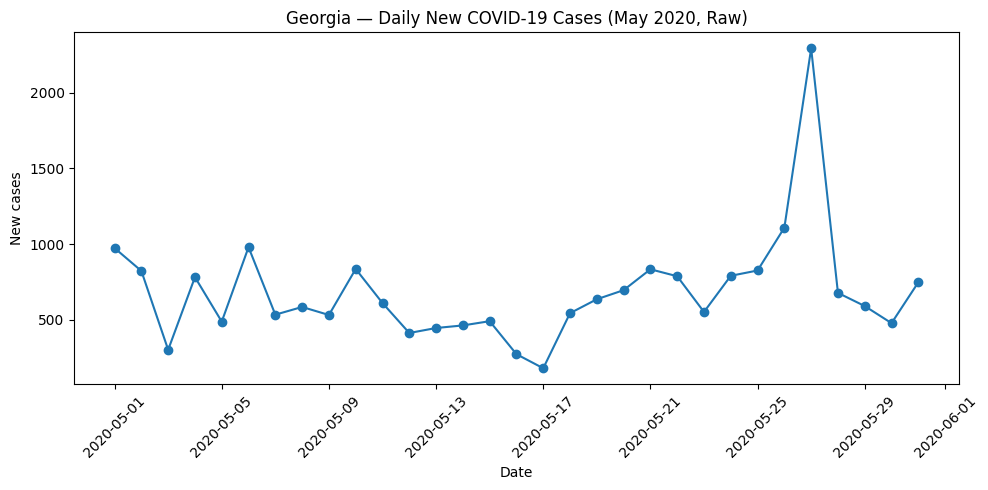

In [8]:
# ---- 2.2 Plot: Exploratory (raw daily new cases) ----
plt.figure(figsize=(10, 5))
plt.figure(figsize=(10, 5))
plt.plot(df_ga_may["date"], df_ga_may["new_cases"], marker="o")
plt.title("Georgia — Daily New COVID-19 Cases (May 2020, Raw)")
plt.xlabel("Date")
plt.ylabel("New cases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


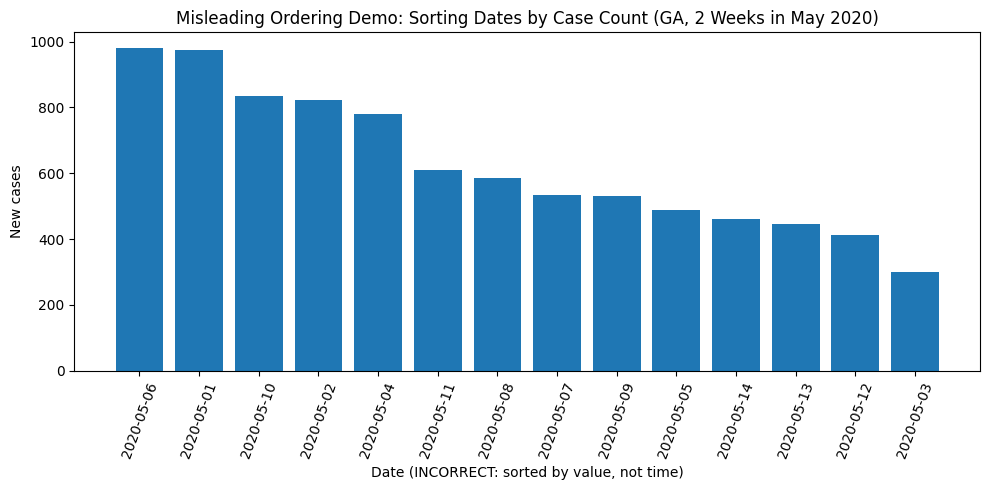

,date,new_cases,label
0,2020-05-06,979.0,2020-05-06
1,2020-05-01,973.0,2020-05-01
2,2020-05-10,835.0,2020-05-10
3,2020-05-02,822.0,2020-05-02
4,2020-05-04,781.0,2020-05-04


In [9]:
# ---- 2.3 Recreate misleading effect ----
segment_start, segment_end = pd.Timestamp("2020-05-01"), pd.Timestamp("2020-05-14")
seg_mask = (df_ga_may["date"] >= segment_start) & (df_ga_may["date"] <= segment_end)
df_seg = df_ga_may.loc[seg_mask, ["date", "new_cases"]].copy()

df_misleading = df_seg.sort_values("new_cases", ascending=False).reset_index(drop=True)
df_misleading["label"] = df_misleading["date"].dt.strftime("%Y-%m-%d")

plt.figure(figsize=(10, 5))
plt.bar(df_misleading["label"], df_misleading["new_cases"])
plt.title("Misleading Ordering Demo: Sorting Dates by Case Count (GA, 2 Weeks in May 2020)")
plt.xlabel("Date (INCORRECT: sorted by value, not time)")
plt.ylabel("New cases")
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

df_misleading.head()

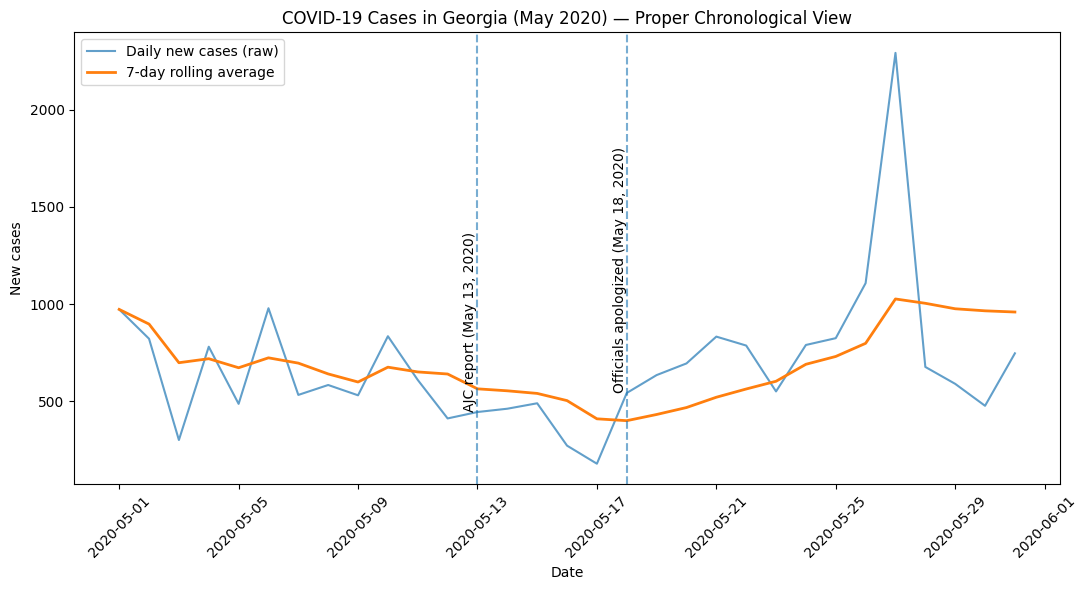

In [11]:
# ---- 2.4 Explanatory plot ----
plt.figure(figsize=(11, 6))
plt.plot(df_ga_may["date"], df_ga_may["new_cases"], alpha=0.7, label="Daily new cases (raw)")
plt.plot(df_ga_may["date"], df_ga_may["new_cases_7d"], linewidth=2, label="7-day rolling average")

ajc_date = pd.Timestamp("2020-05-13")      # Report date cited by Columbia article
apology_date = pd.Timestamp("2020-05-18")  # AP/Route Fifty coverage date

for d, txt in [(ajc_date, "AJC report (May 13, 2020)"),
               (apology_date, "Officials apologized (May 18, 2020)")]:
    yval = float(df_ga_may.loc[df_ga_may["date"] == d, "new_cases"].fillna(df_ga_may["new_cases"].median()).values[0]) \
           if d in set(df_ga_may["date"]) else float(df_ga_may["new_cases"].median())
    plt.axvline(d, linestyle="--", alpha=0.6)
    plt.text(d, yval, txt, rotation=90, va="bottom", ha="right")

plt.title("COVID-19 Cases in Georgia (May 2020) — Proper Chronological View")
plt.xlabel("Date")
plt.ylabel("New cases")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Part 1 — The Misleading Chart Case Study (Georgia DPH, May 2020)
**1. ما الخطأ في الرسم البياني الخاص بوزارة الصحة في جورجيا؟**

الوزارة عرضت بيانات الإصابات اليومية الجديدة بفيروس كورونا لفترة 14 يوماً، لكنها غيّرت ترتيب الأيام على المحور الأفقي من الترتيب الزمني الصحيح إلى ترتيب تنازلي حسب عدد الحالات. هذا التلاعب جعل الرسم البياني يبدو وكأن عدد الإصابات ينخفض بشكل مستمر، بينما الواقع أن الأرقام كانت متقلبة وغير مستقرة.

**2. كيف أثر ذلك على إدراك القارئ (Clarity & Perception)؟**

الناس يفهمون المخططات الزمنية تلقائياً من اليسار إلى اليمين كأنها تمثل مرور الزمن. عندما يُرتّب المحور الزمني بطريقة غير زمنية، ينخدع الإدراك البصري ويظن القارئ أن هناك اتجاهاً تنازلياً. هذا يخلق انطباعاً زائفاً بتحسن الوضع الصحي بينما الواقع مختلف تماماً.

**3. ما الغرض  من الرسم الأصلي؟**

كان الغرض الضمني هو إظهار أن الإصابات تتناقص باستمرار لدعم قرارات إعادة الفتح المبكر في الولاية. إلا أن البيانات الفعلية كانت تُظهر تقلباً في عدد الحالات دون اتجاه نزولي واضح، مما جعل الرسم يضلل صانع القرار والجمهور.

| مبدأ توفتي                           | كيفية الانتهاك                                              |
| ------------------------------------ | ----------------------------------------------------------- |
| **Integrity (النزاهة)**              | تم تشويه المعنى الحقيقي للبيانات عن طريق ترتيب غير زمني.    |
| **Clarity (الوضوح)**                 | تسبب الرسم في إرباك القارئ بدلاً من توضيح الاتجاه الزمني.   |
| **Comparability (إمكانية المقارنة)** | فقدت إمكانية المقارنة بين الأيام لأن ترتيبها لم يعكس الزمن. |

# Part 2 — Python Lab: Exploratory vs. Explanatory Visualisation

**5. ما الهدف من استخدام البيانات من موقع USAFacts؟**

يتيح موقع USAFacts الوصول إلى بيانات موثوقة ومحدثة حول الإصابات اليومية حسب الولايات الأمريكية. باستخدامها يمكن إعادة بناء تحليل موضوعي وصادق لنفس الفترة الزمنية (مايو 2020 في جورجيا) بطريقة شفافة.

**6. ما الفرق بين الرسم الاستكشافي (Exploratory) والرسم التفسيري (Explanatory)؟**
| النوع           | الهدف                                  | الخصائص                                                                |
| --------------- | -------------------------------------- | ---------------------------------------------------------------------- |
| **Exploratory** | استكشاف البيانات وفهم الأنماط الأولية  | غير منسق، خام، يعرض القيم اليومية كما هي                               |
| **Explanatory** | توضيح الرسالة الرئيسية بوضوح وسرد بصري | يحتوي على متوسطات متحركة، تسميات توضيحية، ترتيب زمني دقيق، وعنوان واضح |

**7. كيف يعيد الرسم المضلل خلق الخداع البصري؟**

عند فرز الأيام حسب عدد الإصابات من الأعلى إلى الأدنى، يبدو المخطط وكأن هناك انخفاضاً تدريجياً مستمراً، رغم أن هذه الأيام ليست متتابعة زمنياً. هذا يعيد نفس الخداع الذي استخدمته وزارة الصحة في الرسم الأصلي.

**8. ما الذي يجعل الرسم التفسيري الجديد أكثر مصداقية؟**

الرسم التفسيري:

يعرض الأيام بترتيب زمني صحيح.

يضيف متوسطاً متحركاً لسبعة أيام لتوضيح الاتجاه الحقيقي.

يضع تعليقات (Annotations) لتوضيح الأحداث المهمة مثل:

13 مايو 2020: نشر مقال AJC الذي كشف الخطأ.

18 مايو 2020: اعتذار رسمي من المسؤولين.

يقدم عنواناً واضحاً ومحورين مفهوميْن: التاريخ ← الإصابات الجديدة.
→ النتيجة: عرض صادق وسهل الفهم لاتجاه الإصابات الفعلي

**Part 3 — الاستنتاج (Conclusion)**

تنظيف البيانات والتصميم الصادق للرسوم البيانية يعزز مبدأ الموثوقية (Reliability). الرسم الزمني الصحيح يمنع التضليل البصري ويتيح تفسيراً حقيقياً للاتجاهات. بينما يمكن للتلاعب بالمحاور أو الترتيب أو النطاق أن يشوه الواقع الإحصائي ويؤدي إلى قرارات خاطئة. الالتزام بمبادئ توفتي — الوضوح، النزاهة، المقارنة — يضمن أن التحليل البصري يخدم الفهم لا الإقناع الزائف.